In [206]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader
from PIL import Image
import scipy.spatial.distance as dist
import sys

sys.path.append('./src/modules/')

import EDA, model

In [160]:
df = pd.read_csv('./src/data/model_data.csv')
colordf = pd.read_csv('./src/data/colors.csv')

In [180]:
df.set_index('Unnamed: 0', inplace = True)
colordf.set_index('Unnamed: 0', inplace = True)

colordf['0'] = colordf['0'].apply(lambda x: eval(x))
colordf['1'] = colordf['1'].apply(lambda x: eval(x))
colordf['2'] = colordf['2'].apply(lambda x: eval(x))

In [141]:
simple_df = df[['Price', 'L', 'M', 'S', 'XL', 'XS', 'XXL', 'Feedback', 'VINTAGE']]

In [142]:
kdf = df.drop(columns = ['0', '1', '2'])

In [143]:
kcolumns = kdf.columns
scolumns = simple_df.columns

scaler = StandardScaler()

kdf = pd.DataFrame(scaler.fit_transform(kdf), columns=kcolumns)
simple_df = pd.DataFrame(scaler.fit_transform(simple_df), columns=scolumns)

In [17]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3) 

k_means.fit(kdf) 

cluster_assignments = k_means.predict(kdf) 

In [18]:
print(calinski_harabasz_score(kdf, cluster_assignments))

20168.33160535275


In [19]:
k_means1 = KMeans(n_clusters = 4)

k_means1.fit(kdf)

cluster_assignments1 = k_means1.predict(kdf)

print(calinski_harabasz_score(kdf, cluster_assignments1))

18235.896607139748


In [20]:
pca = PCA()
pca_df = pca.fit_transform(kdf)

In [21]:
np.cumsum(pca.explained_variance_ratio_)

array([0.80389211, 0.94088125, 0.98696391, 0.99593242, 0.99986834,
       0.99999954, 0.99999959, 0.99999963, 0.99999968, 0.99999971,
       0.99999974, 0.99999976, 0.99999978, 0.99999979, 0.99999981,
       0.99999982, 0.99999982, 0.99999983, 0.99999984, 0.99999984,
       0.99999985, 0.99999985, 0.99999986, 0.99999986, 0.99999987,
       0.99999987, 0.99999988, 0.99999988, 0.99999988, 0.99999989,
       0.99999989, 0.99999989, 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.99999991, 0.99999991, 0.99999991, 0.99999991,
       0.99999992, 0.99999992, 0.99999992, 0.99999992, 0.99999992,
       0.99999993, 0.99999993, 0.99999993, 0.99999993, 0.99999993,
       0.99999993, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999994, 0.99999994, 0.99999994, 0.99999995, 0.99999995,
       0.99999995, 0.99999995, 0.99999995, 0.99999995, 0.99999995,
       0.99999995, 0.99999996, 0.99999996, 0.99999996, 0.99999996,
       0.99999996, 0.99999996, 0.99999996, 0.99999996, 0.99999

In [22]:
k_means2 = KMeans(n_clusters = 4)
k_means2.fit(pca_df)

cluster_assignments2 = k_means2.predict(pca_df)

print(calinski_harabasz_score(pca_df, cluster_assignments2))

18281.666713289193


## Cosine Similarity

Cosine similarity is likely the best quantitative measure of the similarity of one row to another. In order to find the most similar items based on my features, I created a function that finds of cosine similarity of a target row and every other item in the DataFrame and returns the top 5 scores and indices. Next, I created a second function to display them. 

In [94]:
def cosine_similarity_recs(input_row, dataframe):
    '''Takes in a row of data and a symmetrical DataFrame, calculates the consine
       similarity of each row with the target and returns a list of the highest 
       scores and their indices'''
    
    # Create an empty list to populate with cosine similarities
    cos_sim = []
    
    # Iterate through every row of the dataframe and add its cosine similarity to the 
    # target row to the list as a tuple including the item's index
    for i in dataframe.index:
        try:
            cos_sim.append((cosine_similarity(input_row, dataframe.iloc[i].values.reshape(1,-1)), i))
        except IndexError:
            continue
    
    # Return a list of the closest cosine similarities and their indices
    return sorted(cos_sim)[-2:-11:-1]

In [144]:
cosine_similarity_recs(kdf.loc[1180:1180], kdf)

[(array([[0.86077461]]), 1164),
 (array([[0.8453186]]), 1197),
 (array([[0.72577301]]), 1266),
 (array([[0.55844488]]), 5193),
 (array([[0.53904603]]), 8510),
 (array([[0.51478903]]), 6891),
 (array([[0.51339071]]), 7348),
 (array([[0.5099981]]), 8088)]

In [146]:
cosine_similarity_recs(simple_df.loc[0:0], simple_df)

[(array([[0.99986931]]), 8555),
 (array([[0.99986931]]), 8498),
 (array([[0.99972291]]), 1523),
 (array([[0.99967784]]), 537),
 (array([[0.99967501]]), 9560),
 (array([[0.99961993]]), 1313),
 (array([[0.99955415]]), 8172),
 (array([[0.99945718]]), 9045)]

In [118]:
def display_cosim_recs(input_row, dataframe):
    ''''''
    
    # Take indices from closest cosine similarities to the target row
    indices = [i[1] for i in cosine_similarity_recs(input_row, dataframe)]
    
    # Create an empty list and append the images from each indice to it, starting
    # with the input row
    images = []
    images.append(Image.open(f'./src/images/{input_row.index[0]}.jpg'))
    for i in indices:
        images.append(Image.open(f'./src/images/{i}.jpg'))
    
    # Display the images
    fig, ax = plt.subplots(2, 3, figsize = (10,6))
    fig.suptitle('Similar items based on cosine similarity', size = 16)
    ax[0,0].imshow(images[0])
    ax[0,0].axis('off')
    ax[0,0].set_title('Original Image')
    ax[0,1].imshow(images[2])
    ax[0,1].axis('off')
    ax[0,1].set_title('Recommendation 1')
    ax[0,2].imshow(images[3])
    ax[0,2].axis('off')
    ax[0,2].set_title('Recommendation 2')
    ax[1,0].imshow(images[4])
    ax[1,0].axis('off')
    ax[1,0].set_title('Recommendation 3')
    ax[1,1].imshow(images[5])
    ax[1,1].axis('off')
    ax[1,1].set_title('Recommendation 4')
    ax[1,2].imshow(images[6])
    ax[1,2].axis('off')
    ax[1,2].set_title('Recommendation 5')

    return plt.show()

Testing the cosine model on a few familiar items- the first matches are from the expanded DataFrame including features from the text descriptions as well as dummy columns for location, brand and size. 

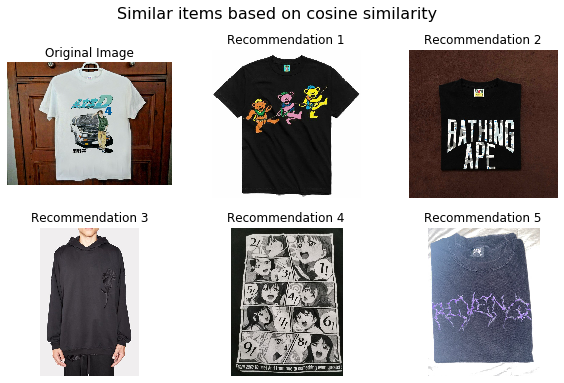

In [147]:
# Find cosine-similar items using the full dataset

display_cosim_recs(kdf.loc[127:127], kdf)

In [ ]:
The second data subset includes only number of likes, price, size and vintage- a binary classifier. On visual inspection, both seemed to perform relatively well but the simpler data returned more aesthetically similar items. 

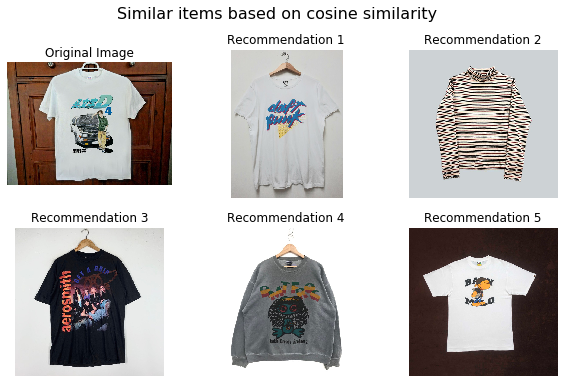

In [148]:
# Find cosine-similar items using the abbreviated dataset

display_cosim_recs(simple_df.loc[127:127], simple_df)

In [ ]:
For a second test, I chose a very expensive listing ($2500) to see what the two datasets would pick up. Up first is the full dataset. It returned an interesting mix of different styles.

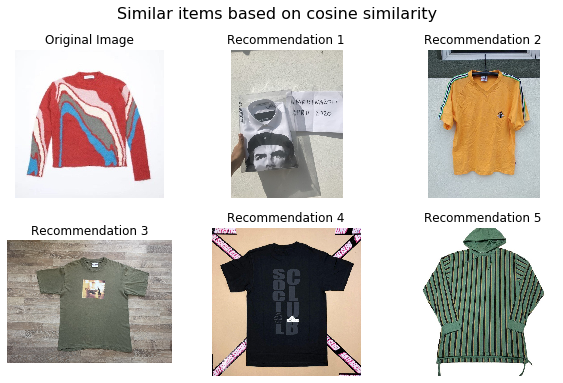

In [151]:
display_cosim_recs(kdf.loc[4363:4363], kdf)

The simple model, where price is a bigger factor (because there are far fewer features) seemed to perform even worse at getting similarly priced items. I think for this to function properly I need to backtrack and scale my data.

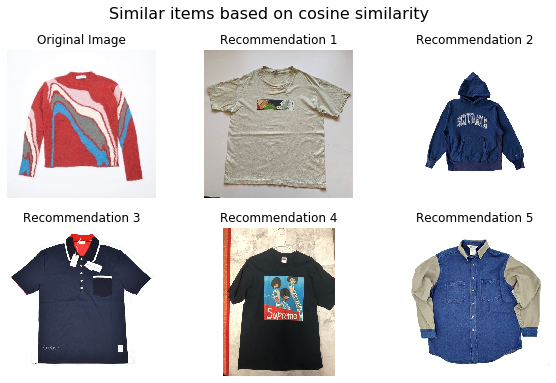

In [150]:
display_cosim_recs(simple_df.loc[4363:4363], simple_df)

In [ ]:
def KNN_recs(input_row, dataframe):

In [ ]:
def support_vector_cluster_recs(input_row, dataframe):

In [ ]:
def kmeans_cluster_recs(input_row, dataframe):

In [199]:
def ensemble_method_recs(input_row, dataframe, color_dataframe):
    cos_sim = []
    color_output = []

    for i in dataframe.index:
        try:
            color_output.append((sum(
                [dist.euclidean(color_dataframe['0'][input_row.index[0]], color_dataframe['0'][i]),
                dist.euclidean(color_dataframe['1'][input_row.index[0]], color_dataframe['1'][i]),
                dist.euclidean(color_dataframe['2'][input_row.index[0]], color_dataframe['2'][i])]), i))
        except KeyError:
            continue

        try:
            cos_sim.append((cosine_similarity(input_row, dataframe.iloc[i].values.reshape(1,-1)), i))
        
        except IndexError:
            continue
    cos_sim = sorted(cos_sim[:-2:])
    for i in range(0, len(cos_sim)):
        cos_sim[i][0] 
        # run forward until the end with increasingly high values, run euclidean backwards and do the same thing?
    return cos_sim
    #create a ranking system based on sorting the lists i.e. the highest cosine similarity gets a score of 10,000, the lowest 1. Add the of the lists together and sort, returning indices of the highest values. Create a dataframe using df.loc[[indices]] print stats- std of Followers, avg cos distance, av euclidean color distance, followed by each item's photo and summary data



In [200]:
ensemble_method_recs(kdf.loc[0:0], kdf, colordf)

TypeError: 'tuple' object does not support item assignment

In [ ]:
Split the dataframe between colors and other data

Separate columns that wouldn't be input by a user- seller data, feedback, etc.

Create functions to find various stats between an input item and the dataframe- cosine similarity, KNN, assigning to a cluster, linear relationships with PCA if possible

Aggregate the methods to create an ensemble classifier that ranks every suggestions based on those metrics

Using the Euclidean distance function, rank the top 1000 closest items by color, then filter down to the top 10 of those using the ensemble classifier

Measure the output by STD of likes, visual inspection and RMSE 

Create function to ouput item photos, name, size, price and link from original dataframe along with the summary data 

In [131]:
kdf.FollowerCount.std()

29.889027881318835

In [134]:
kdf.loc[[12,34,567]].std()

Price              241.160389
Sold               126.633329
Feedback            66.460515
CurrentListings     22.188586
FollowerCount       67.825757
                      ...    
within               0.000000
working              0.000000
worn                 0.000000
you                  0.156615
your                 0.000000
Length: 149, dtype: float64